Here we process the data and extract yearly features

# Intro

When learning the zenith equations, we will need to interpolate between the observations of Ozone. For this we must develop a regression model for the Ozone time-series. The problem is set up as follows:
1. We have observations of Oz at discrete time stamps
2. We have a new time stamp which is not among the observations, but is within the observed interval
3. Using apprpriate technique, find the value of Oz at that time stamp and assess unerctainty.

**Note:**
1. We will ignore geo-location for now and treat the entire time series of Ozone as measured at the same location
2. We will focus on OZCD




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy import interpolate
from pathlib import Path
from pprint import pprint
from copy import deepcopy
import operator

import dill

import seaborn as sns

from pprint import pprint, pp

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
)
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor

import seaborn as sns
from tqdm.notebook import tqdm

import itertools
import functools


# test-train split
# from sktime.forecasting.model_selection import temporal_train_test_split

# # plotter
# from sktime.utils.plotting import plot_series

# # forecasting horizon
# from sktime.forecasting.base import ForecastingHorizon 

# # performanc metric 
# from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# # FORECASTERS

# # list of available forecasters
# from sktime.registry import all_estimators

# from sktime.forecasting.naive import NaiveForecaster
# from sktime.forecasting.theta import ThetaForecaster
# from sktime.forecasting.ets import AutoETS


# from sktime.forecasting.arima import ARIMA
# from sktime.forecasting.arima import AutoARIMA

# from sktime.forecasting.fbprophet import Prophet

# Load and view data

In [4]:
# load pickle
df_direct = pd.read_pickle("df_direct.pkl")
df_zenith = pd.read_pickle("df_zenith.pkl")

In [5]:
# load csv
df_direct.to_csv('Data/df_direct.csv')
df_zenith.to_csv('Data/df_zenith.csv')

In [6]:
df = pd.DataFrame(index = df_direct['dt'], columns = ['OZCD'])
df = df_direct.drop(columns = 'Unnamed: 0').set_index('dt')
df.index.name = None
df['OZCD'] = df['OZCD'].astype(float)

In [7]:
# the following needs some investigation: 2 rows are somehow being flagged as duplicates
# for now, just chuck them

df = df['OZCD'][~df.index.duplicated()]

Plot without tie gaps between observations

**Note: This is a useless and misleading plot, because we clearly have missing seasonal observations in 2018-2020, which are jammed together**

In [8]:
# plot_series(df);

Plot on actual time arrow

**This is revealing of trends**

In [347]:
%matplotlib qt
ax = df_direct.plot('dt', 'OZCD', style = '.', markersize = 1);
ax.set_xlabel('time')
ax.set_ylabel('${Ozone}_{CD}$')

Text(0, 0.5, '${Ozone}_{CD}$')

## Seasonal features

In [11]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    
    
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int64')
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    
    # X = df[['dayofweek','2h',
    #        'hour']]
    
    if label:
        y = df[label]
        return X, y
    return X

In [12]:
df = pd.DataFrame(index = df_direct['dt'], columns = ['OZCD'])
df = df_direct.drop(columns = 'Unnamed: 0').set_index('dt')
df.index.name = None
df['OZCD'] = df['OZCD'].astype(float)
df = df[~df.index.duplicated()]

In [13]:
df, y = create_features(df, 'OZCD')

In [14]:
df['x'] = y

In [15]:
df

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,x
2012-02-05 18:08:00,18,6,1,2,2012,36,5,5,248.0
2012-02-05 19:36:00,19,6,1,2,2012,36,5,5,254.0
2012-02-06 14:51:00,14,0,1,2,2012,37,6,6,238.0
2012-02-06 16:35:00,16,0,1,2,2012,37,6,6,242.0
2012-02-06 17:35:00,17,0,1,2,2012,37,6,6,245.0
...,...,...,...,...,...,...,...,...,...
2020-01-29 09:24:00,9,2,1,1,2020,29,29,5,311.0
2020-01-29 12:12:00,12,2,1,1,2020,29,29,5,295.0
2020-01-29 18:00:00,18,2,1,1,2020,29,29,5,299.0
2020-01-29 22:00:00,22,2,1,1,2020,29,29,5,281.0


The yearly features have high dispersion, because we don't have periodic measurements in later years

<AxesSubplot: xlabel='quarter', ylabel='x'>

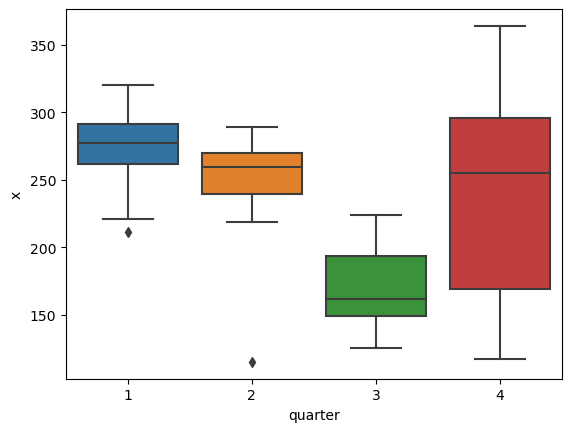

In [16]:
sns.boxplot(data = df, x = 'quarter', y = 'x')

Monthly features look quite promising

<AxesSubplot: xlabel='month', ylabel='x'>

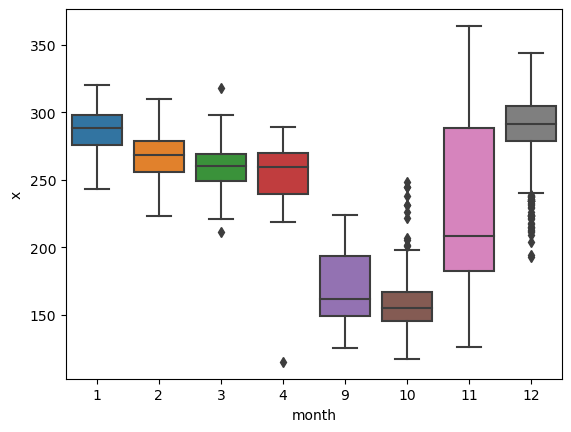

In [17]:
%matplotlib qt
sns.boxplot(data = df, x = 'month', y = 'x')

In [353]:
%matplotlib qt
sns.boxplot(data = df, x = 'month', y = 'x')

<AxesSubplot: xlabel='month', ylabel='x'>

Weekly features have high dispesion

<AxesSubplot: xlabel='weekofyear', ylabel='x'>

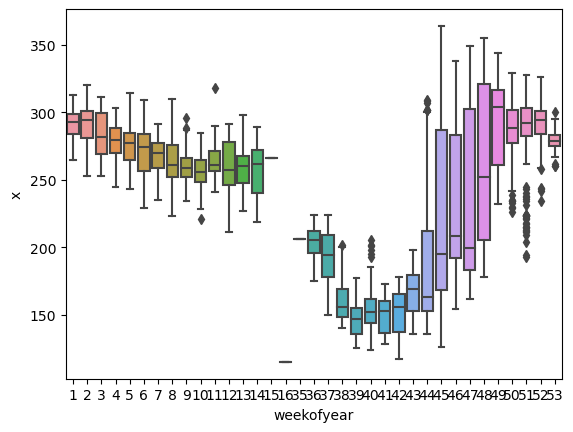

In [20]:
sns.boxplot(data = df, x = 'weekofyear', y = 'x')

In [216]:
sns.boxplot(data = df, x = 'dayofyear', y = 'x')

<AxesSubplot: xlabel='dayofyear', ylabel='x'>

In [67]:
df.to_csv('df_seasonal.csv')

# Rescale time arrow between 1st and last measurements

To apply GP, we might want to rescale to a manageable interval, say [0, 1]. 

We have about 8 years of observations and time stamps have minute resolution, i.e. we have 
$$\approx8\cdot365\cdot24\cdot60=4204800\approx 5\cdot10^6$$
minutes. And observations take place at some of those minutes. 

Let's cast in terms of minutes and rescale

In [21]:
from datetime import datetime, date, time, timedelta
from dateutil.relativedelta import relativedelta

In [ ]:
def roundTime(dt=None, roundTo=60):
   """Round a datetime object to any time lapse in seconds
   dt : datetime.datetime object
   roundTo : Closest number of seconds to round to, default 1 minute.
   """
   seconds = (dt.replace(tzinfo=None) - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + timedelta(0,rounding-seconds,-dt.microsecond)

# map from dt in [0,1] to date-time, where t0->0, dtN -- total number of mins
dt2datetime = lambda dt, t0, dtN: roundTime(t0+timedelta(minutes = dt*dtN))

# date-time to dt in [0,1], where t0->0, dtN -- total number of mins
datetime2dt = lambda x, t0, dtN: (x-t0).total_seconds()/60./dtN

In [22]:
df = df\
.reset_index()\
.rename(columns = {'index':'t', 'OZCD':'x'})

## first measurement -> 0, last -> 1

In [180]:
t0 = df['t'].iloc[0].to_pydatetime()
tN = df['t'].iloc[-1].to_pydatetime()
t0, tN

(datetime.datetime(2012, 2, 5, 18, 8), datetime.datetime(2020, 1, 30, 9, 24))

In [48]:
# Our time interval in minutes
dtN = (tN-t0).total_seconds()/60.
dtN

4198516.0

In [27]:
# Linearly map astronomic time to [0,1]
df['dt']=df['t'].apply(lambda x: (x.to_pydatetime()-t0).total_seconds()/60./dtN)

## Jan 1, 2012 -> 0, Jan 1, 2021 -> 1

In [205]:
ta = datetime(year = 2012, month = 1, day = 1)
tb = datetime(year = 2021, month = 1, day = 1)
dtNab = (tb-ta).total_seconds()/60
df['dtab']=df['t'].apply(lambda x: (x.to_pydatetime()-ta).total_seconds()/60./dtNab)

In [206]:
df

,t,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,x,dt,dtab
0,2012-02-05 18:08:00,18,6,1,2,2012,36,5,5,248.0,0.000000,0.010875
1,2012-02-05 19:36:00,19,6,1,2,2012,36,5,5,254.0,0.000021,0.010893
2,2012-02-06 14:51:00,14,0,1,2,2012,37,6,6,238.0,0.000296,0.011137
3,2012-02-06 16:35:00,16,0,1,2,2012,37,6,6,242.0,0.000321,0.011159
4,2012-02-06 17:35:00,17,0,1,2,2012,37,6,6,245.0,0.000335,0.011172
...,...,...,...,...,...,...,...,...,...,...,...,...
3383,2020-01-29 09:24:00,9,2,1,1,2020,29,29,5,311.0,0.999657,0.897321
3384,2020-01-29 12:12:00,12,2,1,1,2020,29,29,5,295.0,0.999697,0.897357
3385,2020-01-29 18:00:00,18,2,1,1,2020,29,29,5,299.0,0.999780,0.897430
3386,2020-01-29 22:00:00,22,2,1,1,2020,29,29,5,281.0,0.999837,0.897481


## Calendar features for [Jan 1, 2012, Jan 1, 2021] -> [0, 1]

By observing the figure, we can see that we can have the following feautures:
1. Yearly, i.e. 52-week
2. winter 6-months
3. summer 6-months
4. every 3-months
5. first trimester of each and last trimester of each year

The data seems to fall perfectly into the following three features
1. 52-week year
2. first yearly trimester
3. last yearly trimester



In [286]:
# for x in [0,1], the sub-interval feature is x_f, given below. 
# it will be almost periodic if a good feature is selected
interval_feature = lambda x, interval: x/interval-(x//interval)

In [283]:
# constant intervals of dt in [0,1], corresponding to astronomical day, week, etc

dt_min = 1./dtNab
dt_day = dt_min*60*24
dt_week = dt_day*7

# these are constant-interval features
# they will not correspond to calendar exactly!
dt_month = dt_week*4
dt_year = dt_week*52

dt_trimester = dt_year/3.
dt_quarter = dt_year/4.

In [344]:
52*7

364

In [284]:
# exact astronomical intervals: months, years, 3-months
dt_astro_months = [datetime2dt(ta+relativedelta(months = i), ta, dtNab) for i in range(8*12+2)]
dt_astro_years = [datetime2dt(ta+relativedelta(years = i), ta, dtNab) for i in range(10)]
dt_astro_months = [datetime2dt(ta+relativedelta(months = 3*i), ta, dtNab) for i in range((9*12+3)//3)]

In [285]:
[dt_astro_years[i]-dt_astro_years[i-1] for i in range(1, 10)], dt_year

([0.11131386861313869,
  0.11100973236009731,
  0.11100973236009731,
  0.11100973236009737,
  0.11131386861313869,
  0.11100973236009726,
  0.11100973236009737,
  0.11100973236009737,
  0.11131386861313863],
 0.11070559610705594)

Text(0, 0.5, '${Ozone}_{CD}$')

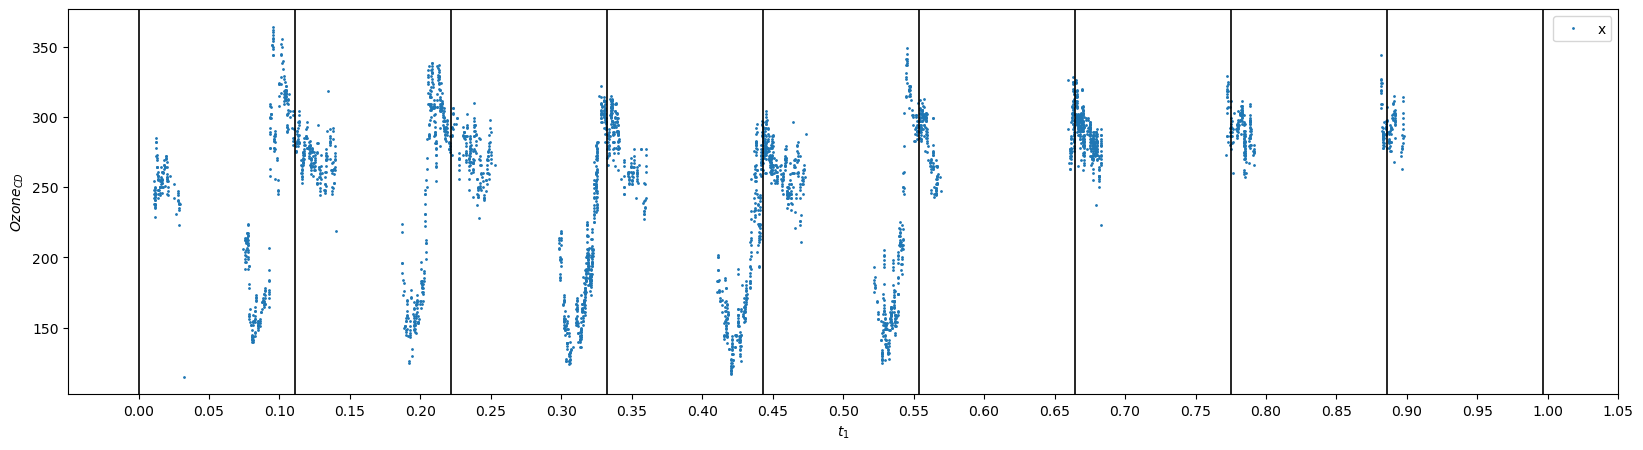

In [357]:
%matplotlib inline

fig, ax = plt.subplots(figsize = (20,5))

# start on January 1, 2012
dt_0 = datetime2dt(datetime(year = 2012, month = 1, day = 1), t0, dtN)

p = df.plot('dtab', 'x', style = 'o', ms = 1, ax = ax)

# astronomical years
# for x in dt_astro_years:
#     p.axvline(x, color = 'tab:red', linestyle = '-', linewidth = .5)

# astronomical 3-months    
# for x in dt_astro_months:
#     p.axvline(x, color = 'tab:green', linestyle = '--', linewidth = .5)

# 52-week years, starting at jan 1, 2012
for x in np.arange(0, 1., dt_year):
    p.axvline(x, color = 'black', linestyle = '-', linewidth = 1.2)

# 52-week years, starting at jan 1, 2012
# for x in np.arange(0, 1., dt_trimester):
#     p.axvline(x, color = 'tab:green', linestyle = '--', linewidth = 1.)

p.set_xticks(np.arange(0.,1.1,.05));

p.set_xlabel('$t_1$')
p.set_ylabel('${Ozone}_{CD}$')

In [361]:
%matplotlib qt

fig, ax = plt.subplots(figsize = (20,5))

# start on January 1, 2012
dt_0 = datetime2dt(datetime(year = 2012, month = 1, day = 1), t0, dtN)

p = df.plot('dtab', 'x', style = 'o', ms = 1, ax = ax)

# astronomical years
# for x in dt_astro_years:
#     p.axvline(x, color = 'tab:red', linestyle = '-', linewidth = .5)

# astronomical 3-months    
# for x in dt_astro_months:
#     p.axvline(x, color = 'tab:green', linestyle = '--', linewidth = .5)

# 52-week years, starting at jan 1, 2012
for x in np.arange(1.5*dt_trimester, 1., dt_year):
    p.axvline(x, color = 'black', linestyle = '-', linewidth = 1.2)

# 52-week years, starting at jan 1, 2012
for x in np.arange(0, 1., dt_trimester):
    p.axvline(x, color = 'tab:green', linestyle = '--', linewidth = 1.)

p.set_xticks(np.arange(0.,1.1,.05));

p.set_xlabel('$t_1$')
p.set_ylabel('${Ozone}_{CD}$')

Text(0, 0.5, '${Ozone}_{CD}$')

In [314]:
x = .15
interval = dt_trimester

int(x//interval%3)

1

### 52-week year feature

Let's find the position of a point within a regularised year (52 weeks)

In [233]:
dt_year

0.11070559610705594

In [252]:
0.22/dt_year-(0.22//dt_year)

0.9872527472527477

In [287]:
df['reg_year_dtab']=df['dtab'].apply(lambda x: interval_feature(x, dt_year))

In [291]:
df

,t,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,x,dt,dtab,reg_year_dtab
0,2012-02-05 18:08:00,18,6,1,2,2012,36,5,5,248.0,0.000000,0.010875,0.098230
1,2012-02-05 19:36:00,19,6,1,2,2012,36,5,5,254.0,0.000021,0.010893,0.098397
2,2012-02-06 14:51:00,14,0,1,2,2012,37,6,6,238.0,0.000296,0.011137,0.100601
3,2012-02-06 16:35:00,16,0,1,2,2012,37,6,6,242.0,0.000321,0.011159,0.100799
4,2012-02-06 17:35:00,17,0,1,2,2012,37,6,6,245.0,0.000335,0.011172,0.100914
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,2020-01-29 09:24:00,9,2,1,1,2020,29,29,5,311.0,0.999657,0.897321,0.105472
3384,2020-01-29 12:12:00,12,2,1,1,2020,29,29,5,295.0,0.999697,0.897357,0.105792
3385,2020-01-29 18:00:00,18,2,1,1,2020,29,29,5,299.0,0.999780,0.897430,0.106456
3386,2020-01-29 22:00:00,22,2,1,1,2020,29,29,5,281.0,0.999837,0.897481,0.106914


Visualise yearly features. We see that really we need more features here. Let's try 

In [356]:
%matplotlib qt
p = df.plot('reg_year_dtab','x', style = 'o', ms = 1)
p.set_xlabel('$t_2$')
p.set_ylabel('${Ozone}_{CD}$')

Text(0, 0.5, '${Ozone}_{CD}$')

<AxesSubplot: xlabel='dtab'>

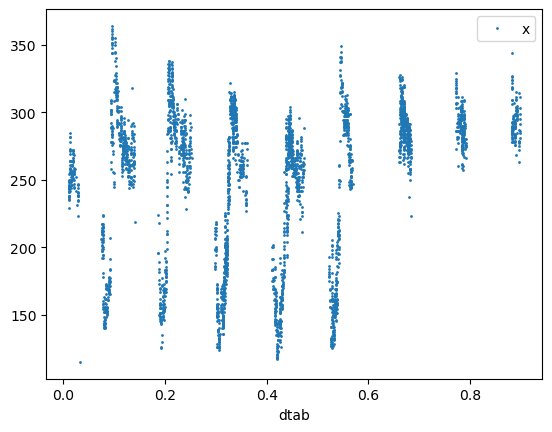

In [260]:
%matplotlib inline
df.plot('dtab','x', style = 'o', ms = 1)

In [321]:
df.to_csv('Data/Ozone_time_series.csv')

### Trimester feature


In [292]:
df['trimester_dtab']=df['dtab'].apply(lambda x: interval_feature(x, dt_trimester))

Let's plot the trimester feature. It shows a multimodal distribution. 

Clearly, we need to consider something like a mixture over the 3 trimesters. 

<AxesSubplot: xlabel='trimester_dtab'>

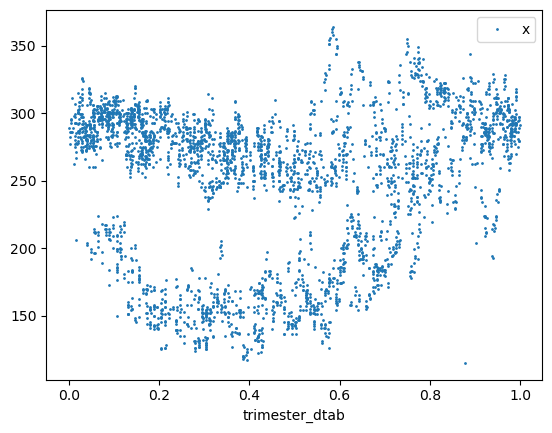

In [294]:
%matplotlib inline
df.plot('trimester_dtab','x', style = 'o', ms = 1)

Let's assign the trimester index and plot 1st, 2nd and 3rd trimesters

In [318]:
df['trimester_ind_dtab']=df['dtab'].apply(lambda x: int(x//dt_trimester%3))

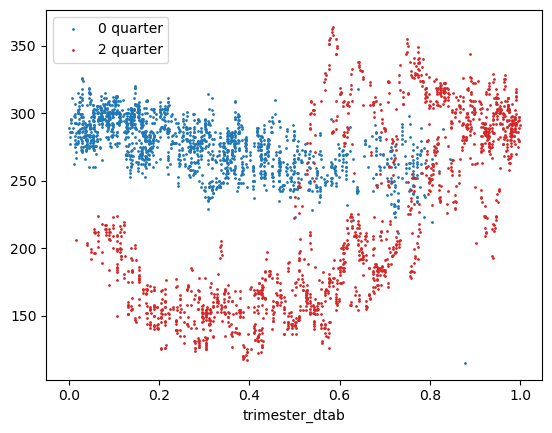

In [330]:
%matplotlib inline
p = df.query('trimester_ind_dtab==0').\
plot('trimester_dtab','x', style = 'o', color = 'tab:blue', ms = 1)

df.query('trimester_ind_dtab==2').\
plot('trimester_dtab','x', style = 'o', color = 'tab:red', ms = 1, ax = p)

p.legend(['0 quarter', '2 quarter'])

In [331]:
dt_trimester

0.03690186536901865

# Convert from [0,1] to date-time

In [ ]:
# to get back date from a random iota in [0,1]
iota = np.random.uniform()
t_iota = t0+timedelta(minutes = iota*dtN)
t_iota, roundTime(t_iota)

# Querry points

Our querry points are times of zenith measurements. Let's place them on our time scale

## uniform
For testing, let's also place a uniform mesh of points in terms dtab and reg_year_dtab

## zenith

In [15]:
# get zenith times within direct time frame
ind_zenith= ((df_zenith.dt>df['t'].iloc[0]) & (df_zenith.dt<df['t'].iloc[-1]))

In [16]:
date_zen = df_zenith.dt[ind_zenith]\
.reset_index()\
.drop(columns = 'index')\
.rename(columns = {'dt':'t'})
date_zen['dt']=date_zen['t'].apply(lambda x: (x.to_pydatetime()-t0).total_seconds()/60./dtN)
date_zen

,t,dt
0,2012-02-05 19:40:00,0.000022
1,2012-02-06 08:36:00,0.000207
2,2012-02-06 09:59:00,0.000227
3,2012-02-06 13:00:30,0.000270
4,2012-02-06 14:55:30,0.000297
...,...,...
66455,2020-01-30 09:00:00,0.999994
66456,2020-01-30 09:05:00,0.999995
66457,2020-01-30 09:10:00,0.999997
66458,2020-01-30 09:15:00,0.999998


Quick check with conversion back to date:

In [17]:
roundTime(t0+timedelta(minutes = tq[2]*dtN))

NameError: name 'tq' is not defined

In [18]:
tq = date_zen['dt'].values
tq.shape

(66460,)

In [20]:
%matplotlib qt
plt.plot(df.dt, df.x, '.')

To appreciate the amounts of data, let's plot known measurements and querry points on a small interval within the timeframe

(0.85, 0.89)

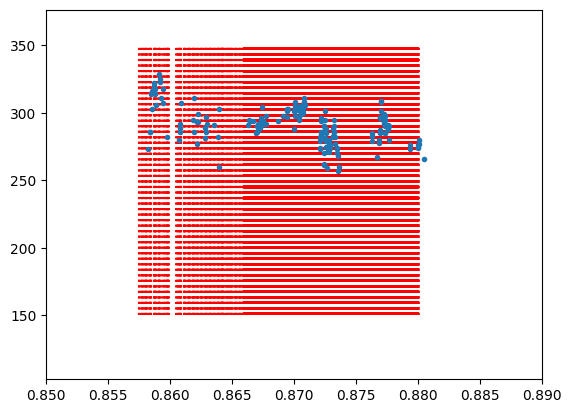

In [116]:
%matplotlib inline
plt.vlines(tq[(tq>.85) & (tq<.88)], 150., 350., colors = 'r', linestyles = ':');
# plt.scatter(tq, 150.*np.ones(tq.shape), .5, color = 'r')
plt.plot(df.dt, df.x, '.')
plt.xlim([.85, .89])